In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [4]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [5]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [6]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [7]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [8]:
def calculate_target(row):
    global fee, delta, stop_loss, treshold
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + treshold:
        if volatility > 0:
            return 0
            # return 1
            # if row['Open'] - row['Low'] > stop_loss:
            #     return 0
            # else:
            #     return 1
        else:
            return 1
            # if row['High'] - row['Open'] > stop_loss:
            #     return 0
            # else:
            #     return (-1)
    else:
        return 0
    # df['target'] = df.apply(calculate_target, axis=1)
    # df.target = df.target.shift(-1)
    return df


def create_trade_outcomes(df, contracts, treshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(calculate_target, axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [9]:
treshold = 300
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, treshold)
gold_gains.head(20)

            gains     Open     High      Low   Settle  target
Date                                                         
1996-01-02  342.0  38830.0  39200.0  38800.0  39190.0       0
1996-01-03  361.0  39240.0  39630.0  39220.0  39620.0       0
1996-01-04   95.0  39440.0  39580.0  39410.0  39540.0       0
1996-01-05 -123.5  39780.0  39920.0  39620.0  39650.0       0
1996-01-09  104.5  39580.0  39710.0  39480.0  39690.0       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0,0.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0,0.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0,0.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0,0.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0,0.0
1996-01-10,-66.5,40000.0,40060.0,39880.0,39930.0,0.0
1996-01-11,-361.0,40050.0,40090.0,39650.0,39670.0,1.0
1996-01-12,133.0,39470.0,39630.0,39400.0,39610.0,0.0
1996-01-15,142.5,39730.0,39890.0,39720.0,39880.0,0.0


In [10]:
get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,388.3,392.0,388.0,391.9,41453.0,57500.0,2.500000,0.0
1996-01-03,392.4,396.3,392.2,396.2,102217.0,79518.0,1.204819,0.0
1996-01-04,394.4,395.8,394.1,395.4,37223.0,83787.0,10.843373,0.0
1996-01-05,397.8,399.2,396.2,396.5,49601.0,89355.0,24.107143,0.0
1996-01-09,395.8,397.1,394.8,396.9,27499.0,90634.0,20.535714,0.0
1996-01-10,397.8,403.0,397.8,400.2,74480.0,103163.0,18.666667,0.0
1996-01-11,400.0,400.6,398.8,399.3,40319.0,103776.0,24.666667,1.0
1996-01-12,400.5,400.9,396.5,396.7,45436.0,97237.0,42.000000,0.0
1996-01-15,394.7,396.3,394.0,396.1,32344.0,95690.0,46.000000,0.0


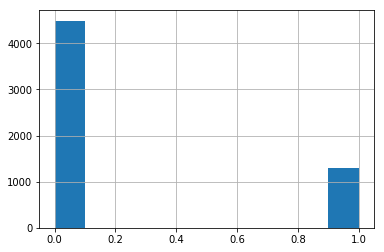

In [11]:
gold['target'].hist()

In [12]:
gold_gains.gains.describe()

count     5780.000000
mean         2.190917
std        903.824695
min     -11390.500000
25%       -237.500000
50%          9.500000
75%        294.500000
max       6555.000000
Name: gains, dtype: float64

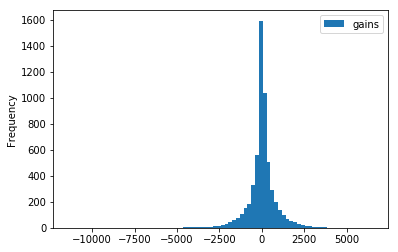

In [13]:
gold_gains[['gains']].plot.hist(bins=80)

In [14]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
treshold = 100
corn_gains = create_trade_outcomes(corn, contracts, treshold)
corn_gains.head(5)

              gains     Open     High      Low   Settle  target
Date                                                           
1996-01-02  106.875  18550.0  18762.5  18512.5  18662.5       0
1996-01-03   47.500  18650.0  18725.0  18512.5  18700.0       0
1996-01-04 -213.750  18675.0  18687.5  18250.0  18450.0       1
1996-01-05  -11.875  18337.5  18450.0  18275.0  18325.0       0
1996-01-08 -190.000  18225.0  18225.0  18000.0  18025.0       1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,0.0


In [15]:
corn_gains.gains.describe()

count    5789.000000
mean        2.203101
std       310.165899
min     -1983.125000
25%      -118.750000
50%         0.000000
75%       130.625000
max      1888.125000
Name: gains, dtype: float64

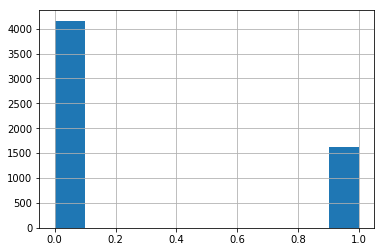

In [16]:
get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.target.hist()

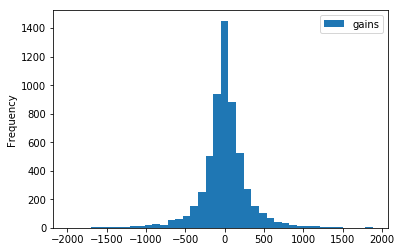

In [17]:
corn_gains[['gains']].plot.hist(bins=40)

In [18]:
corn_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,0.0
1996-01-09,-249.375,18375.0,18375.0,18100.0,18112.5,1.0
1996-01-10,-225.625,18112.5,18112.5,17800.0,17875.0,1.0
1996-01-11,237.500,17887.5,18150.0,17887.5,18137.5,0.0
1996-01-12,142.500,18100.0,18262.5,18075.0,18250.0,0.0


In [19]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
treshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, treshold)
coffee_gains.head(5)

                gains     Open      High      Low    Settle  target
Date                                                               
1996-01-02  -480.9375  34725.0  35550.00  34162.5  34218.75       1
1996-01-03  1015.3125  34087.5  35400.00  33900.0  35156.25       0
1996-01-04  1727.8125  34875.0  36787.50  34875.0  36693.75       0
1996-01-05  -445.3125  36562.5  37293.75  35925.0  36093.75       1
1996-01-10   890.6250  35775.0  36843.75  35550.0  36712.50       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,1015.3125,34087.5,35400.00,33900.00,35156.25,0.0
1996-01-03,1727.8125,34875.0,36787.50,34875.00,36693.75,0.0
1996-01-04,-445.3125,36562.5,37293.75,35925.00,36093.75,1.0
1996-01-05,890.6250,35775.0,36843.75,35550.00,36712.50,0.0
1996-01-10,1977.1875,36562.5,38812.50,36468.75,38643.75,0.0


In [20]:
coffee_gains.gains.describe()

count     5751.000000
mean        -2.638889
std        968.552015
min     -12842.812500
25%       -213.750000
50%          0.000000
75%        231.562500
max       6929.062500
Name: gains, dtype: float64

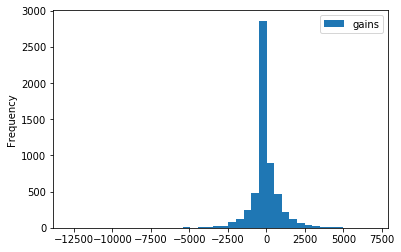

In [21]:
coffee_gains[['gains']].plot.hist(bins=40)

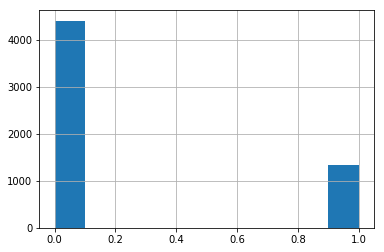

In [22]:
get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.target.hist()

In [23]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-04,93.00,98.10,93.00,97.85,8865.0,18918.0,3.246753,1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,1.0
1996-01-29,116.95,123.90,116.95,123.45,8731.0,14053.0,1.546392,1.0
1996-01-31,120.00,131.50,120.00,128.60,11395.0,15577.0,8.592593,1.0
1996-02-01,128.00,129.25,125.80,126.40,5198.0,15628.0,15.111111,1.0
1996-02-02,127.00,130.75,121.00,123.75,8588.0,14732.0,22.962963,1.0
1996-02-05,124.00,124.75,119.75,120.65,4248.0,12778.0,37.094017,1.0
1996-02-09,124.50,127.20,124.50,126.05,4373.0,10734.0,21.206226,1.0
1996-02-21,120.90,124.25,119.25,123.30,6467.0,16657.0,52.650177,1.0


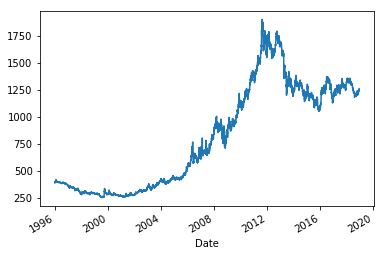

In [24]:
gold['Open'].plot()

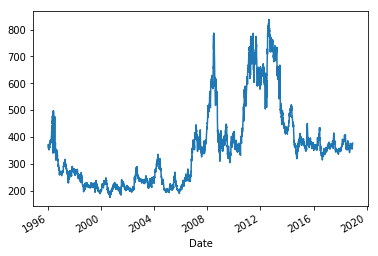

In [25]:
corn['Open'].plot()

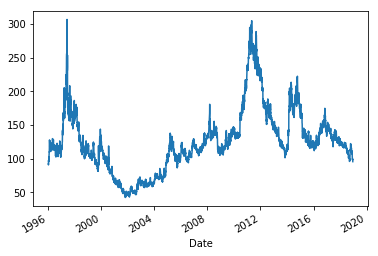

In [26]:
coffee['Open'].plot()

In [27]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [28]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [29]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,0.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,0.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,0.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,0.0


In [30]:
gold_data.shape

(5276, 3046)

In [31]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [32]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [33]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 3045
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)

    # pca_lst = []
    # pca = PCA(n_components=50, random_state=2234)
    pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(3040))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)

    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3040))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    return df_pca

In [34]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [35]:
# plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [36]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [37]:
def plot_pca_relation(pca_data, label_train, x):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    for i in range(x):
        for j in range(i+1, x):
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in labels:
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()

In [38]:
pca_components = 3

In [100]:
# plot_pca_relation(gold_pca[0].transform(gold_train[list(range(2016))]), gold_label_train, pca_components)

In [101]:
# plot_pca_relation(corn_pca[0].transform(corn_train[list(range(2016))]), corn_label_train, pca_components)

In [102]:
# plot_pca_relation(coffee_pca[0].transform(coffee_train[list(range(2016))]), coffee_label_train, pca_components)

In [118]:
# gold_label_test.head(20)

In [137]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import lightgbm as lgb
import xgboost as xgb


X = pca_transform(gold_train, gold_pca)
train_data = lgb.Dataset(X, label=list(map(lambda x: x, gold_label_train)), categorical_feature='auto') # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x, gold_label_test)), categorical_feature='auto')
param = {}
param = {'num_leaves':31, 'objective':'binary'}
param['objective'] = 'binary'
# param['metric'] = 'logloss'
# param['boosting_type'] = 'gbdt'
# param['metric'] = 'rmse'
param['boosting'] = 'dart'
param['max_bin'] = 50
# param['metric'] = 'multi_error'
param['metric'] = 'binary_error'
param['learning_rate'] = 0.05
param['num_class'] = 1
param['max_bin'] = 50
num_round = 2000
# param = {'boosting_type': 'gbdt',
#          'max_depth' : -1,
#           'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 64,
#           'learning_rate': 0.05,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 1,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 5,
#           'reg_lambda': 10,
#           'min_split_gain': 0.5,
#           'min_child_weight': 1,
#           'min_child_samples': 5,
#           'scale_pos_weight': 1,
#           'num_class' : 1,
#           'metric' : 'binary_error'}
gold_xgb_use = False
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# gold_clf = RandomForestClassifier(n_estimators=150, random_state=1100)
# gold_clf = AdaBoostClassifier(n_estimators=100, random_state=1100, learning_rate=0.1)
# gold_clf = MLPClassifier(hidden_layer_sizes=(100, 3), solver='sgd', random_state=1100)
# gold_clf = MLPRegressor(hidden_layer_sizes=(100, 3), solver='sgd', max_iter=2000, alpha=0.1, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, gold_label_train))
# gold_clf.fit(X, gold_label_train)
# gold_clf.fit(X, gold_label_train, sample_weight=sample_weight)

[1]	valid_0's binary_error: 0.362657
[2]	valid_0's binary_error: 0.362657
[3]	valid_0's binary_error: 0.362657
[4]	valid_0's binary_error: 0.362657
[5]	valid_0's binary_error: 0.362657
[6]	valid_0's binary_error: 0.362657
[7]	valid_0's binary_error: 0.362657
[8]	valid_0's binary_error: 0.362657
[9]	valid_0's binary_error: 0.362657
[10]	valid_0's binary_error: 0.362657
[11]	valid_0's binary_error: 0.362657
[12]	valid_0's binary_error: 0.362657
[13]	valid_0's binary_error: 0.362657
[14]	valid_0's binary_error: 0.364452
[15]	valid_0's binary_error: 0.366248
[16]	valid_0's binary_error: 0.369838
[17]	valid_0's binary_error: 0.373429
[18]	valid_0's binary_error: 0.375224
[19]	valid_0's binary_error: 0.373429
[20]	valid_0's binary_error: 0.373429
[21]	valid_0's binary_error: 0.371634
[22]	valid_0's binary_error: 0.371634
[23]	valid_0's binary_error: 0.375224
[24]	valid_0's binary_error: 0.375224
[25]	valid_0's binary_error: 0.375224
[26]	valid_0's binary_error: 0.37702
[27]	valid_0's binary_

[244]	valid_0's binary_error: 0.40754
[245]	valid_0's binary_error: 0.40395
[246]	valid_0's binary_error: 0.40754
[247]	valid_0's binary_error: 0.409336
[248]	valid_0's binary_error: 0.409336
[249]	valid_0's binary_error: 0.409336
[250]	valid_0's binary_error: 0.40754
[251]	valid_0's binary_error: 0.409336
[252]	valid_0's binary_error: 0.409336
[253]	valid_0's binary_error: 0.409336
[254]	valid_0's binary_error: 0.411131
[255]	valid_0's binary_error: 0.409336
[256]	valid_0's binary_error: 0.409336
[257]	valid_0's binary_error: 0.40754
[258]	valid_0's binary_error: 0.40754
[259]	valid_0's binary_error: 0.40754
[260]	valid_0's binary_error: 0.405745
[261]	valid_0's binary_error: 0.405745
[262]	valid_0's binary_error: 0.40754
[263]	valid_0's binary_error: 0.40754
[264]	valid_0's binary_error: 0.409336
[265]	valid_0's binary_error: 0.411131
[266]	valid_0's binary_error: 0.411131
[267]	valid_0's binary_error: 0.411131
[268]	valid_0's binary_error: 0.412926
[269]	valid_0's binary_error: 0.41

[505]	valid_0's binary_error: 0.421903
[506]	valid_0's binary_error: 0.421903
[507]	valid_0's binary_error: 0.418312
[508]	valid_0's binary_error: 0.420108
[509]	valid_0's binary_error: 0.420108
[510]	valid_0's binary_error: 0.421903
[511]	valid_0's binary_error: 0.421903
[512]	valid_0's binary_error: 0.423698
[513]	valid_0's binary_error: 0.420108
[514]	valid_0's binary_error: 0.421903
[515]	valid_0's binary_error: 0.421903
[516]	valid_0's binary_error: 0.421903
[517]	valid_0's binary_error: 0.421903
[518]	valid_0's binary_error: 0.421903
[519]	valid_0's binary_error: 0.421903
[520]	valid_0's binary_error: 0.421903
[521]	valid_0's binary_error: 0.420108
[522]	valid_0's binary_error: 0.420108
[523]	valid_0's binary_error: 0.420108
[524]	valid_0's binary_error: 0.418312
[525]	valid_0's binary_error: 0.418312
[526]	valid_0's binary_error: 0.420108
[527]	valid_0's binary_error: 0.420108
[528]	valid_0's binary_error: 0.420108
[529]	valid_0's binary_error: 0.418312
[530]	valid_0's binary_er

[747]	valid_0's binary_error: 0.425494
[748]	valid_0's binary_error: 0.425494
[749]	valid_0's binary_error: 0.427289
[750]	valid_0's binary_error: 0.425494
[751]	valid_0's binary_error: 0.427289
[752]	valid_0's binary_error: 0.427289
[753]	valid_0's binary_error: 0.427289
[754]	valid_0's binary_error: 0.427289
[755]	valid_0's binary_error: 0.427289
[756]	valid_0's binary_error: 0.427289
[757]	valid_0's binary_error: 0.427289
[758]	valid_0's binary_error: 0.429084
[759]	valid_0's binary_error: 0.425494
[760]	valid_0's binary_error: 0.425494
[761]	valid_0's binary_error: 0.425494
[762]	valid_0's binary_error: 0.423698
[763]	valid_0's binary_error: 0.423698
[764]	valid_0's binary_error: 0.423698
[765]	valid_0's binary_error: 0.425494
[766]	valid_0's binary_error: 0.425494
[767]	valid_0's binary_error: 0.425494
[768]	valid_0's binary_error: 0.425494
[769]	valid_0's binary_error: 0.423698
[770]	valid_0's binary_error: 0.423698
[771]	valid_0's binary_error: 0.423698
[772]	valid_0's binary_er

[970]	valid_0's binary_error: 0.425494
[971]	valid_0's binary_error: 0.427289
[972]	valid_0's binary_error: 0.427289
[973]	valid_0's binary_error: 0.427289
[974]	valid_0's binary_error: 0.427289
[975]	valid_0's binary_error: 0.427289
[976]	valid_0's binary_error: 0.425494
[977]	valid_0's binary_error: 0.425494
[978]	valid_0's binary_error: 0.427289
[979]	valid_0's binary_error: 0.427289
[980]	valid_0's binary_error: 0.427289
[981]	valid_0's binary_error: 0.425494
[982]	valid_0's binary_error: 0.425494
[983]	valid_0's binary_error: 0.43088
[984]	valid_0's binary_error: 0.43088
[985]	valid_0's binary_error: 0.43088
[986]	valid_0's binary_error: 0.43088
[987]	valid_0's binary_error: 0.43088
[988]	valid_0's binary_error: 0.429084
[989]	valid_0's binary_error: 0.429084
[990]	valid_0's binary_error: 0.429084
[991]	valid_0's binary_error: 0.43088
[992]	valid_0's binary_error: 0.43088
[993]	valid_0's binary_error: 0.43088
[994]	valid_0's binary_error: 0.427289
[995]	valid_0's binary_error: 0.4

[1186]	valid_0's binary_error: 0.411131
[1187]	valid_0's binary_error: 0.409336
[1188]	valid_0's binary_error: 0.409336
[1189]	valid_0's binary_error: 0.411131
[1190]	valid_0's binary_error: 0.409336
[1191]	valid_0's binary_error: 0.411131
[1192]	valid_0's binary_error: 0.409336
[1193]	valid_0's binary_error: 0.411131
[1194]	valid_0's binary_error: 0.412926
[1195]	valid_0's binary_error: 0.412926
[1196]	valid_0's binary_error: 0.412926
[1197]	valid_0's binary_error: 0.412926
[1198]	valid_0's binary_error: 0.412926
[1199]	valid_0's binary_error: 0.412926
[1200]	valid_0's binary_error: 0.412926
[1201]	valid_0's binary_error: 0.412926
[1202]	valid_0's binary_error: 0.412926
[1203]	valid_0's binary_error: 0.412926
[1204]	valid_0's binary_error: 0.412926
[1205]	valid_0's binary_error: 0.412926
[1206]	valid_0's binary_error: 0.411131
[1207]	valid_0's binary_error: 0.412926
[1208]	valid_0's binary_error: 0.412926
[1209]	valid_0's binary_error: 0.412926
[1210]	valid_0's binary_error: 0.411131


[1435]	valid_0's binary_error: 0.418312
[1436]	valid_0's binary_error: 0.418312
[1437]	valid_0's binary_error: 0.418312
[1438]	valid_0's binary_error: 0.418312
[1439]	valid_0's binary_error: 0.416517
[1440]	valid_0's binary_error: 0.416517
[1441]	valid_0's binary_error: 0.416517
[1442]	valid_0's binary_error: 0.416517
[1443]	valid_0's binary_error: 0.416517
[1444]	valid_0's binary_error: 0.416517
[1445]	valid_0's binary_error: 0.418312
[1446]	valid_0's binary_error: 0.418312
[1447]	valid_0's binary_error: 0.418312
[1448]	valid_0's binary_error: 0.418312
[1449]	valid_0's binary_error: 0.418312
[1450]	valid_0's binary_error: 0.418312
[1451]	valid_0's binary_error: 0.420108
[1452]	valid_0's binary_error: 0.420108
[1453]	valid_0's binary_error: 0.420108
[1454]	valid_0's binary_error: 0.420108
[1455]	valid_0's binary_error: 0.420108
[1456]	valid_0's binary_error: 0.420108
[1457]	valid_0's binary_error: 0.421903
[1458]	valid_0's binary_error: 0.421903
[1459]	valid_0's binary_error: 0.421903


[1660]	valid_0's binary_error: 0.425494
[1661]	valid_0's binary_error: 0.427289
[1662]	valid_0's binary_error: 0.425494
[1663]	valid_0's binary_error: 0.429084
[1664]	valid_0's binary_error: 0.43088
[1665]	valid_0's binary_error: 0.429084
[1666]	valid_0's binary_error: 0.43088
[1667]	valid_0's binary_error: 0.43088
[1668]	valid_0's binary_error: 0.43088
[1669]	valid_0's binary_error: 0.43088
[1670]	valid_0's binary_error: 0.429084
[1671]	valid_0's binary_error: 0.427289
[1672]	valid_0's binary_error: 0.427289
[1673]	valid_0's binary_error: 0.427289
[1674]	valid_0's binary_error: 0.427289
[1675]	valid_0's binary_error: 0.427289
[1676]	valid_0's binary_error: 0.427289
[1677]	valid_0's binary_error: 0.429084
[1678]	valid_0's binary_error: 0.427289
[1679]	valid_0's binary_error: 0.427289
[1680]	valid_0's binary_error: 0.425494
[1681]	valid_0's binary_error: 0.427289
[1682]	valid_0's binary_error: 0.425494
[1683]	valid_0's binary_error: 0.425494
[1684]	valid_0's binary_error: 0.425494
[1685

[1887]	valid_0's binary_error: 0.421903
[1888]	valid_0's binary_error: 0.427289
[1889]	valid_0's binary_error: 0.427289
[1890]	valid_0's binary_error: 0.427289
[1891]	valid_0's binary_error: 0.427289
[1892]	valid_0's binary_error: 0.427289
[1893]	valid_0's binary_error: 0.423698
[1894]	valid_0's binary_error: 0.425494
[1895]	valid_0's binary_error: 0.423698
[1896]	valid_0's binary_error: 0.425494
[1897]	valid_0's binary_error: 0.425494
[1898]	valid_0's binary_error: 0.425494
[1899]	valid_0's binary_error: 0.425494
[1900]	valid_0's binary_error: 0.425494
[1901]	valid_0's binary_error: 0.425494
[1902]	valid_0's binary_error: 0.425494
[1903]	valid_0's binary_error: 0.425494
[1904]	valid_0's binary_error: 0.427289
[1905]	valid_0's binary_error: 0.427289
[1906]	valid_0's binary_error: 0.427289
[1907]	valid_0's binary_error: 0.427289
[1908]	valid_0's binary_error: 0.423698
[1909]	valid_0's binary_error: 0.421903
[1910]	valid_0's binary_error: 0.421903
[1911]	valid_0's binary_error: 0.421903


In [138]:
%%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)

y = list(map(lambda x: x, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: x, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
corn_xgb_use = False
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [139]:
%%capture cpt_coffee_train
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: x, coffee_label_train)), categorical_feature='auto')
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x, coffee_label_test)), categorical_feature='auto')
coffee_xgb_use = False
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [140]:
# X_test = pca_transform(corn_test, corn_pca)
# corn_clf.score(X_test, corn_label_test)

In [170]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, xgb_use=False, stop_loss=500):
    global account_size, fee
    acc = account_size
    df = pca_transform(df, pca)
    if not xgb_use:
        preds = model.predict(df)
        predictions = []
        for p in preds:
            if p > 0.45:
                predictions.append(-1)
            else:
                predictions.append(0)
            # predictions.append(0)
    else:
        preds = list(map(lambda x: x, model.predict(df)))
        predictions = []
        for s, n, l in preds:
            if s > 0.55:
                predictions.append(-1)
            elif l > 0.55:
                predictions.append(1)
            predictions.append(0)
    print(np.unique(predictions))
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1:
            # print("Short ", p, l)
            short = 1
            if (v[2] - v[1]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1:
            long = 1
            if (v[1] - v[3]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(p)
        dct['label'].append(l)
        dct['gains'].append(gains)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

[-1  0]


(0, 18000)

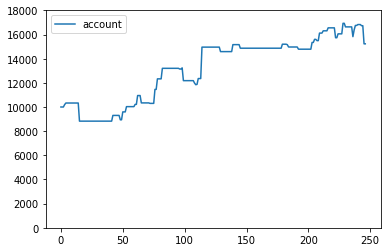

In [171]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, xgb_use=gold_xgb_use, stop_loss=1500)
ax1 = gold_account[['account']].plot()
ax1.set_ylim(0,18000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09c2e07048>,
      dtype=object)

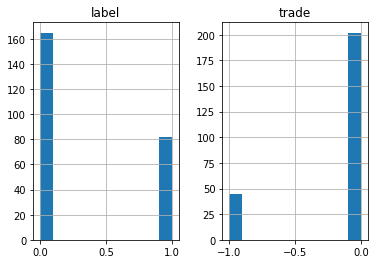

In [172]:
gold_account[['trade', 'label']].hist()

In [173]:
gold_account[gold_account['short'] == 1].gains.sum()

5229.000000000041

In [174]:
gold_account[gold_account['long'] == 1].gains.sum()

0.0

[-1  0]


(0, 12000)

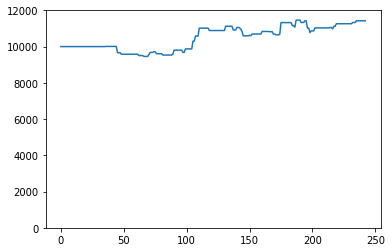

In [175]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, xgb_use=corn_xgb_use, stop_loss=400)
ax1 = corn_account.account.plot()
ax1.set_ylim(0,12000)

In [176]:
corn_account[corn_account['short'] == 1].gains.sum()

1423.5

In [177]:
corn_account[corn_account['long'] == 1].gains.sum()

0.0

[-1  0]


(0, 14000)

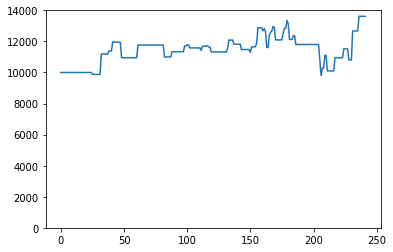

In [178]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, xgb_use=coffee_xgb_use, stop_loss=1000)
ax1 = coffee_account.account.plot()
ax1.set_ylim(0,14000)

In [179]:
coffee_account[coffee_account['short'] == 1].gains.sum()

3618.0000000000005

In [176]:
coffee_account[coffee_account['long'] == 1].gains.sum()

0.0